In [10]:
import os

import torch

import schnetpack.nn 
import schnetpack.data
import schnetpack as spk
from schnetpack.datasets import QM9


import schnetpack.train as trn
from torch.optim import Adam

# Define the model parameters and train

In [11]:
def train_schnet_model(trained_model_path,qm9data,num_train,num_val,n_in,n_atomic_basis,n_filters,n_gaussians,n_interactions,cutoff):
    trained_model_path = trained_model_path
    if not os.path.exists(trained_model_path):
        os.makedirs(trained_model_path)

    qm9data=qm9data
    train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=num_train,
        num_val=num_val,
        split_file=os.path.join(trained_model_path,'split.npz')
        )


    train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
    val_loader = spk.AtomsLoader(val, batch_size=100)



    means, stddevs = train_loader.get_statistics(QM9.mu, divide_by_atoms=True, single_atom_ref=atomrefs)


    print('Mean dipole moment / atom:', means[QM9.mu])
    print('Std. dev. dipole moment / atom:', stddevs[QM9.mu])

    # Define output model and property to be predicted
    schnet = spk.representation.SchNet(
        n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=3,
        cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
    )
    output_dip = spk.atomistic.DipoleMoment(n_in=n_in, property=QM9.mu,
                                   mean=means[QM9.mu], contributions=True, stddev=stddevs[QM9.mu])
    model = spk.AtomisticModel(representation=schnet, output_modules=output_dip)

    # loss function
    def mse_loss(batch, result):
        diff = batch[QM9.mu]-result[QM9.mu]
        err_sq = torch.mean(diff ** 2)
        return err_sq

    # build optimizer
    optimizer = Adam(model.parameters(), lr=1e-2)

    loss = trn.build_mse_loss([QM9.mu])

    metrics = [spk.metrics.MeanAbsoluteError(QM9.mu)]
    hooks = [
        trn.CSVHook(log_path=trained_model_path, metrics=metrics),
        trn.ReduceLROnPlateauHook(
            optimizer,
            patience=5, factor=0.8, min_lr=1e-6,
            stop_after_min=True
        )
    ]

    trainer = trn.Trainer(
        model_path=trained_model_path,
        model=model,
        hooks=hooks,
        loss_fn=loss,
        optimizer=optimizer,
        keep_n_checkpoints = 10,
        train_loader=train_loader,
        validation_loader=val_loader,
    )

    device = "cpu" # change to 'cpu' if gpu is not available
    n_epochs = 1000 # takes about 10 min on a notebook GPU. reduces for playing around
    trainer.train(device=device, n_epochs=n_epochs)

    import numpy as np
    import matplotlib.pyplot as plt
    from ase.units import kcal, mol

    results = np.loadtxt(os.path.join(trained_model_path, 'log.csv'), skiprows=1, delimiter=',')

    time = results[:,0]-results[0,0]
    learning_rate = results[:,1]
    train_loss = results[:,2]
    val_loss = results[:,3]
    val_mae = results[:,4]

    print('Final validation MAE:', np.round(val_mae[-1], 2), 'Debye')

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(time, val_loss, label='Validation')
    plt.plot(time, train_loss, label='Train')
    plt.yscale('log')
    plt.ylabel('Loss [Debye]')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(time, val_mae)
    plt.ylabel('mean abs. error [Debye]')
    plt.xlabel('Time [s]')
    plt.show()

    checkpoint_path = trained_model_path + '/trained.pth'
    torch.save(model.state_dict(), checkpoint_path)

Mean dipole moment / atom: tensor([0.0324])
Std. dev. dipole moment / atom: tensor([0.0209])
None
Final validation MAE: 0.02 Debye


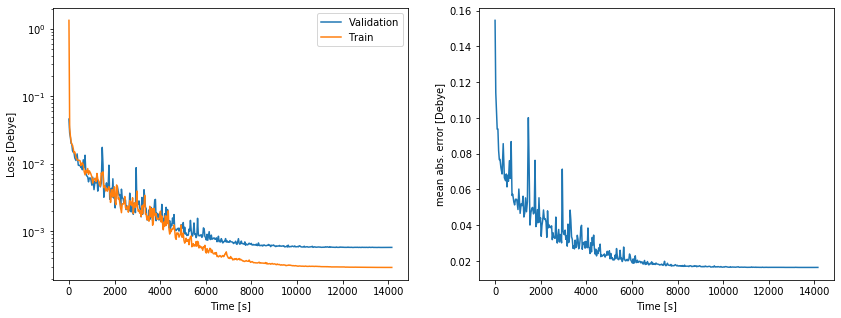

In [12]:
trained_model_path = '../../../new_trained_modeld/qm9_dipole_trained'
qm9data = QM9('./qm9.db', download=True, remove_uncharacterized=True, load_only=[QM9.mu])
num_train = 10000
num_val = 5000
n_in = 30
n_atomic_basis = 30
n_filters = 30 
n_gaussians = 20
n_interactions = 3
cutoff = 4

train_schnet_model(trained_model_path,qm9data,num_train,num_val,n_in,n_atomic_basis,n_filters,n_gaussians,n_interactions,cutoff)